## Data Preprocessing, Data cleaning 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.pandas.set_option("display.max_columns", 100)
# Create Dataframe
df = pd.read_csv('marketing_campaign.csv', sep='\t')
# Print shape of dataset
print(df.shape)

(2240, 29)


In [2]:
##these are the features with nan value
features_with_na=[features for features in df.columns if df[features].isnull().sum()>=1]
for feature in features_with_na:
    print(feature,np.round(df[feature].isnull().mean()*100,5), '% missing values')

Income 1.07143 % missing values


In [3]:
# statistics on numerical columns (Null cols)
df[features_with_na].select_dtypes(exclude='object').describe()

,Income
count,2216.000000
mean,52247.251354
std,25173.076661
min,1730.000000
25%,35303.000000
50%,51381.500000
75%,68522.000000
max,666666.000000


In [4]:
#Age
df.Income.fillna(df.Income.median(), inplace=True)
df.duplicated().sum()
columns_to_drop = ['ID', 'Z_CostContact','Z_Revenue']
for column in columns_to_drop:
    df.drop(column, inplace=True, axis=1)
    print(f"Column {column} is dropped.")

Column ID is dropped.
Column Z_CostContact is dropped.
Column Z_Revenue is dropped.


## Feature Engineering 

In [5]:
# create new column for feature

from datetime import datetime


df = df.copy()

##  creating a new field to store the Age of the customer
df['Age']=2022-df['Year_Birth']   

###  recoding the customer's education level to numeric form (0: high-school, 1: diploma, 2: bachelors, 3: masters, and 4: doctorates)
df["Education"].replace({"Basic":0,"2n Cycle":1, "Graduation":2, "Master":3, "PhD":4},inplace=True)  

#  recoding the customer's marital status to numeric form (0: not living with a partner, 1: living with a partner) 
df['Marital_Status'].replace({"Married":1, "Together":1, "Absurd":0, "Widow":0, "YOLO":0, "Divorced":0, "Single":0,"Alone":0},inplace=True) 

#  creating a new field to store the number of children in the household
df['Children']=df['Kidhome']+df['Teenhome']

#creating Family_Size
df['Family_Size']=df['Marital_Status']+df['Children']+1



#  creating a new field to store the total spending of the customer
df['Total_Spending'] = (df["MntWines"] + df["MntFruits"] + df["MntMeatProducts"] + 
                        df["MntFishProducts"] + df["MntSweetProducts"] + df["MntGoldProds"])
df["Total Promo"] = (df["AcceptedCmp1"] + df["AcceptedCmp2"] + 
                     df["AcceptedCmp3"] + df["AcceptedCmp4"] + df["AcceptedCmp5"])

## The following code works out how long the customer has been with the company and store the total number of promotions the customers responded to
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y', errors='coerce')
today = datetime.today()
df['Days_as_Customer']=(today-df['Dt_Customer']).dt.days
df['Offers_Responded_To']=df['AcceptedCmp1']+df['AcceptedCmp2']+df['AcceptedCmp3']+df['AcceptedCmp4']+df['AcceptedCmp5']+df['Response']
df["Parental Status"] = np.where(df["Children"] > 0, 1, 0)






#dropping columns which are already used to create new features
columns_to_drop = ['Year_Birth','Kidhome','Teenhome']
df.drop(columns = columns_to_drop, axis = 1, inplace=True)
df.rename(columns={"Marital_Status": "Marital Status","MntWines": "Wines","MntFruits":"Fruits",
                   "MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets",
                   "MntGoldProds":"Gold","NumWebPurchases": "Web","NumCatalogPurchases":"Catalog",
                   "NumStorePurchases":"Store","NumDealsPurchases":"Discount Purchases"},
          inplace = True)

df = df[["Age","Education","Marital Status","Parental Status","Children","Income","Total_Spending","Days_as_Customer","Recency","Wines","Fruits","Meat","Fish","Sweets","Gold","Web","Catalog","Store","Discount Purchases","Total Promo","NumWebVisitsMonth"]]

print(df.head())

   Age  Education  Marital Status  Parental Status  Children   Income  \
0   65          2               0                0         0  58138.0   
1   68          2               0                1         2  46344.0   
2   57          2               1                0         0  71613.0   
3   38          2               1                1         1  26646.0   
4   41          4               1                1         1  58293.0   

   Total_Spending  Days_as_Customer  Recency  Wines  Fruits  Meat  Fish  \
0            1617              4556       58    635      88   546   172   
1              27              4006       38     11       1     6     2   
2             776              4205       26    426      49   127   111   
3              53              4032       26     11       4    20    10   
4             422              4054       94    173      43   118    46   

   Sweets  Gold  Web  Catalog  Store  Discount Purchases  Total Promo  \
0      88    88    8       10      4 

In [6]:
num_features = [feature for feature in df.columns if df[feature].dtype != 'O']
print('Num of Numerical Features :', len(num_features))
cat_features = [feature for feature in df.columns if df[feature].dtype == 'O']
print('Num of Categorical Features :', len(cat_features))
discrete_features=[feature for feature in num_features if len(df[feature].unique())<=25]
print('Num of Discrete Features :',len(discrete_features))
continuous_features=[feature for feature in num_features if feature not in discrete_features]
print('Num of Continuous Features :',len(continuous_features))
continuous_features

Num of Numerical Features : 21
Num of Categorical Features : 0
Num of Discrete Features : 10
Num of Continuous Features : 11


['Age',
 'Income',
 'Total_Spending',
 'Days_as_Customer',
 'Recency',
 'Wines',
 'Fruits',
 'Meat',
 'Fish',
 'Sweets',
 'Gold']

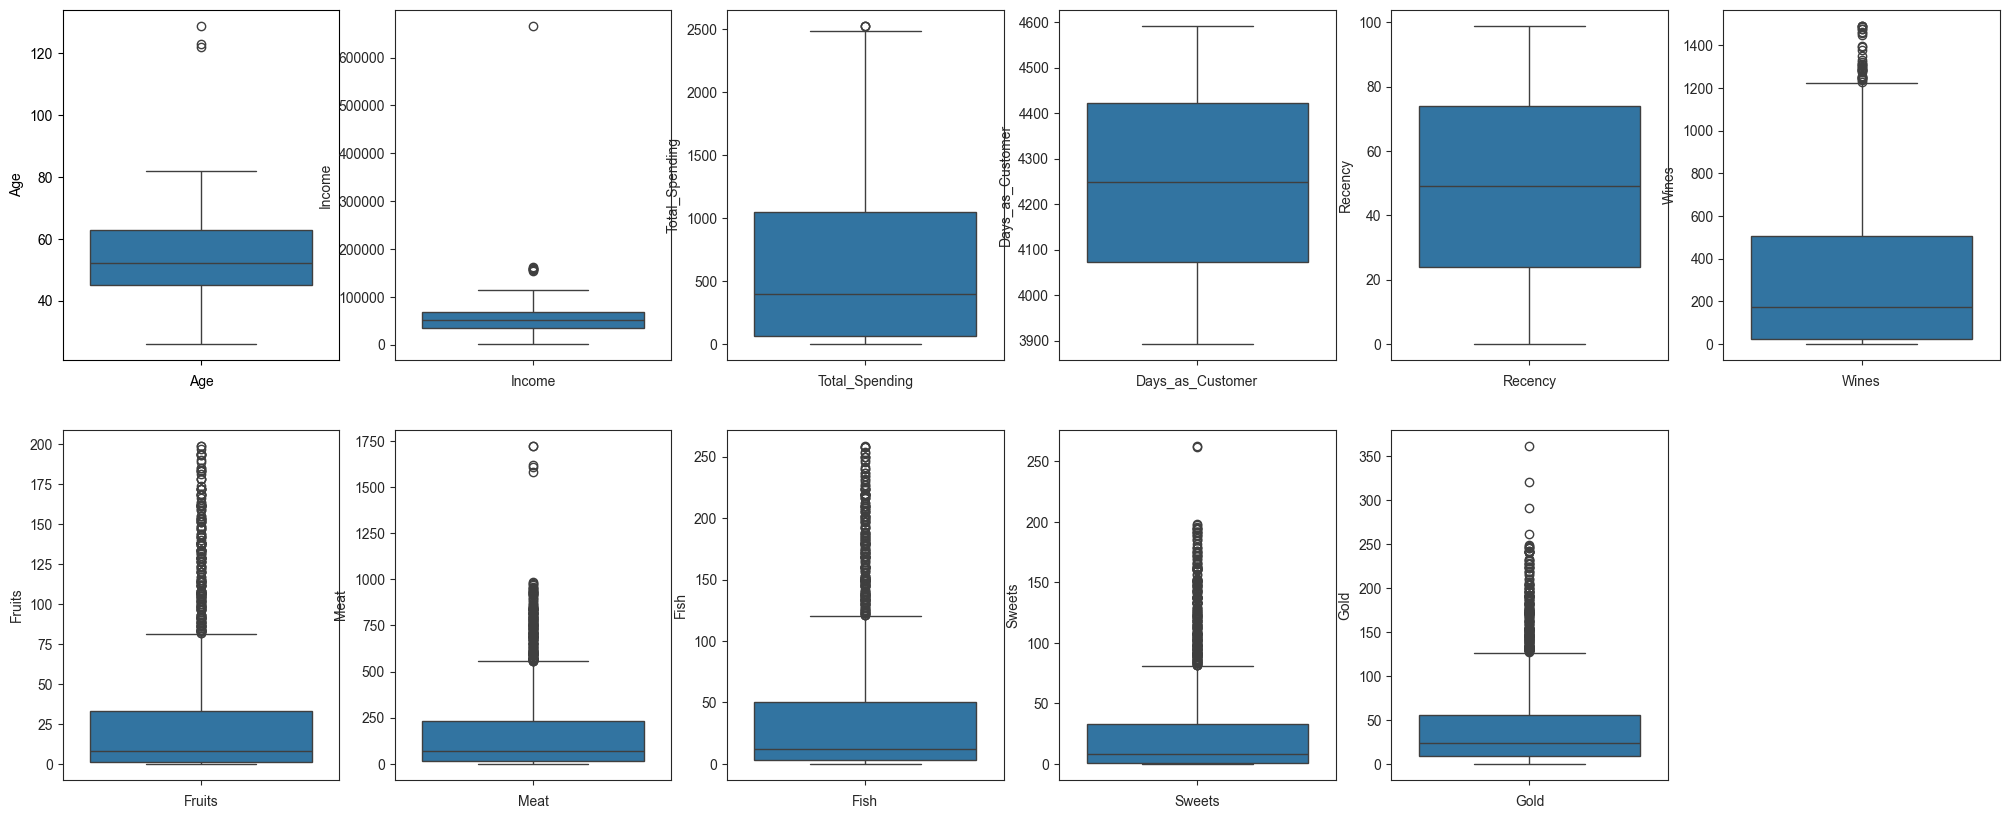

In [7]:
cont_features = continuous_features.copy()
plt.figure(figsize=(25, 10))

for i in range(len(cont_features)):
        plt.subplot(2,6,i+1)
        sns.set_style('ticks')
        plt.xlabel(cont_features[i])
        ax = sns.boxplot(df[cont_features[i]])

def detect_outliers(col):
    # Finding the IQR
    percentile25 = df[col].quantile(0.25)
    percentile75 = df[col].quantile(0.75)
    print('\n ####', col , '####')
    print("percentile25",percentile25)
    print("percentile75",percentile75)
    iqr = percentile75 - percentile25
    upper_limit = percentile75 + 1.5 * iqr
    lower_limit = percentile25 - 1.5 * iqr
    print("Upper limit",upper_limit)
    print("Lower limit",lower_limit)
    df.loc[(df[col]>upper_limit), col]= upper_limit
    df.loc[(df[col]<lower_limit), col]= lower_limit    
    return df

In [8]:
for col in continuous_features:
         detect_outliers(col)


 #### Age ####
percentile25 45.0
percentile75 63.0
Upper limit 90.0
Lower limit 18.0

 #### Income ####
percentile25 35538.75
percentile75 68289.75
Upper limit 117416.25
Lower limit -13587.75

 #### Total_Spending ####
percentile25 68.75
percentile75 1045.5
Upper limit 2510.625
Lower limit -1396.375

 #### Days_as_Customer ####
percentile25 4073.75
percentile75 4422.0
Upper limit 4944.375
Lower limit 3551.375

 #### Recency ####
percentile25 24.0
percentile75 74.0
Upper limit 149.0
Lower limit -51.0

 #### Wines ####
percentile25 23.75
percentile75 504.25
Upper limit 1225.0
Lower limit -697.0

 #### Fruits ####
percentile25 1.0
percentile75 33.0
Upper limit 81.0
Lower limit -47.0

 #### Meat ####
percentile25 16.0
percentile75 232.0
Upper limit 556.0
Lower limit -308.0

 #### Fish ####
percentile25 3.0
percentile75 50.0
Upper limit 120.5
Lower limit -67.5

 #### Sweets ####
percentile25 1.0
percentile75 33.0
Upper limit 81.0
Lower limit -47.0

 #### Gold ####
percentile25 9.0
percenti

In [9]:
df[continuous_features].skew(axis=0, skipna=True)
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'O']
outlier_features = ["Wines","Fruits","Meat","Fish","Sweets","Gold","Age","Total_Spending"] #we can find the columns which has oitliers in the EDA
numeric_features = [x for x in numeric_features if x not in outlier_features]

In [10]:
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline




dataC = df.copy()

numeric_pipeline = Pipeline(steps=
                            [("Imputer", SimpleImputer(strategy='constant', fill_value=0)), 
                             ("StandardScaler", StandardScaler())]
                           )

outlier_features_pipeline = Pipeline(steps=
                                     [("Imputer", SimpleImputer(strategy='constant', fill_value=0)),
                                      ("transformer", PowerTransformer(standardize=True))]
                                    )

preprocessor = ColumnTransformer(
    [
        ("numeric pipeline",numeric_pipeline, numeric_features),
        ("Outliers Features Pipeline", outlier_features_pipeline, outlier_features)
    ]
)

columns = dataC.columns
dataC = preprocessor.fit_transform(dataC)
scaled_data = pd.DataFrame(dataC, columns= columns )
print("After scaling, let's have a glimpse of the scaled dataset :")
scaled_data.head()

After scaling, let's have a glimpse of the scaled dataset :


,Age,Education,Marital Status,Parental Status,Children,Income,Total_Spending,Days_as_Customer,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,Web,Catalog,Store,Discount Purchases,Total Promo,NumWebVisitsMonth
0,-0.458383,-1.346874,-1.584605,-1.264505,0.299651,1.531185,0.307039,1.409304,2.510890,-0.550785,0.349414,-0.439037,0.693904,1.062784,1.487681,1.504406,1.493989,1.474200,1.196801,1.005341,1.315365
1,-0.458383,-1.346874,0.631072,1.396361,-0.263808,-1.190545,-0.383664,-1.110409,-0.568720,-1.166125,-0.168236,-0.439037,-0.130463,-1.211545,-1.001121,-1.376502,-0.889143,-0.987648,-0.967034,1.239521,-1.441417
2,-0.458383,0.742460,-1.584605,-1.264505,0.943420,-0.205773,-0.798086,1.409304,-0.226541,1.295237,-0.685887,-0.439037,-0.542647,0.748918,1.145877,0.456428,1.435812,0.579704,0.473642,0.361223,0.661170
3,-0.458383,0.742460,0.631072,0.065928,-1.204881,-1.061881,-0.798086,-0.750450,-0.910898,-0.550785,-0.168236,-0.439037,0.281720,-1.211545,-0.403311,-0.722233,-0.110828,-0.542753,-1.069040,-1.315014,-1.117211
4,1.533425,0.742460,0.631072,0.065928,0.307056,-0.953012,1.550305,0.329427,0.115638,0.064556,1.384715,-0.439037,-0.130463,0.123712,1.058075,0.406278,0.832291,0.741799,-0.368949,-1.033428,0.179322


In [11]:
# this function we take it from sklearn page for ploting silhouette with little Modification 
#ploting silhouette_plot aside with clustring results in PCA
from sklearn.metrics import silhouette_score,silhouette_samples
from matplotlib import cm

def silhouette_plot(model,range_n_clusters,X_clustering,pca,**kwargs):
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X_clustering) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = model(n_clusters,**kwargs)
        cluster_labels = clusterer.fit_predict(X_clustering)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X_clustering, cluster_labels)
        print(
            "For n_clusters =",
            n_clusters,
            "The average silhouette_score is :",
            silhouette_avg,
        )

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X_clustering, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.2,-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
    #     colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)

        sns.scatterplot(
            x = pca[:, 0],
            y = pca[:, 1],
            hue=cluster_labels,
            palette=sns.color_palette("colorblind", len(set(cluster_labels))),
            alpha=0.7,
            legend="full",
            ax = ax2
        )
        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(
            f"Silhouette analysis for {model.__name__} clustering on sample data with n_clusters = %d"
            % n_clusters,
            fontsize=14,
            fontweight="bold",
        )

    plt.show()

## Customer Segmentation Using Flying Fox Optimization Algorithm

In [12]:
df.head()

,Age,Education,Marital Status,Parental Status,Children,Income,Total_Spending,Days_as_Customer,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,Web,Catalog,Store,Discount Purchases,Total Promo,NumWebVisitsMonth
0,65,2,0,0,0,58138.0,1617.0,4556.0,58,635,81,546,120.5,81,88.0,8,10,4,3,0,7
1,68,2,0,1,2,46344.0,27.0,4006.0,38,11,1,6,2.0,1,6.0,1,1,2,2,0,5
2,57,2,1,0,0,71613.0,776.0,4205.0,26,426,49,127,111.0,21,42.0,8,2,10,1,0,4
3,38,2,1,1,1,26646.0,53.0,4032.0,26,11,4,20,10.0,3,5.0,2,0,4,2,0,6
4,41,4,1,1,1,58293.0,422.0,4054.0,94,173,43,118,46.0,27,15.0,5,3,6,5,0,5


In [13]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Select features for clustering
features = ['Age', 'Education', 'Marital Status', 'Parental Status', 'Children',
            'Income', 'Total_Spending', 'Days_as_Customer', 'Recency', 'Wines',
            'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold', 'Web', 'Catalog',
            'Store', 'Discount Purchases', 'Total Promo', 'NumWebVisitsMonth']

X = df[features].values

# Standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- FFOA Implementation ---

# Parameters
num_foxes = 10      # Population size
num_clusters = 5    # Number of customer segments (clusters)
max_iter = 100      # Number of iterations
alpha = 0.5         # Convergence rate
beta = 0.3          # Exploration factor

# Initialize foxes (solutions)
foxes = [np.random.uniform(np.min(X_scaled), np.max(X_scaled), (num_clusters, X_scaled.shape[1])) for _ in range(num_foxes)]

# Fitness function: Sum of squared distances within clusters (K-Means inertia)
def fitness(centroids):
    kmeans = KMeans(n_clusters=num_clusters, init=centroids, n_init=1, max_iter=300)
    kmeans.fit(X_scaled)
    return kmeans.inertia_  # Lower inertia means better clustering

# Evolution loop
for iteration in range(max_iter):
    # Evaluate fitness for all foxes
    fitness_scores = np.array([fitness(fox) for fox in foxes])
    
    # Best fox (solution with lowest inertia)
    best_index = np.argmin(fitness_scores)
    best_fox = foxes[best_index]

    # Update positions (exploration & exploitation)
    new_foxes = []
    for fox in foxes:
        if np.random.rand() < 0.5:  # Exploration
            new_fox = fox + beta * (np.random.rand(*fox.shape) - 0.5)
        else:  # Exploitation (move towards best fox)
            new_fox = fox + alpha * (best_fox - fox) + beta * (np.random.rand(*fox.shape) - 0.5)
        new_foxes.append(new_fox)

    foxes = new_foxes  # Update population

# Final optimized cluster centers
optimal_centroids = foxes[np.argmin([fitness(fox) for fox in foxes])]

# Apply K-Means with optimized centroids
final_kmeans = KMeans(n_clusters=num_clusters, init=optimal_centroids, n_init=1, max_iter=300)
df['Cluster'] = final_kmeans.fit_predict(X_scaled)

# Show segmented customers
print(df[['Age', 'Income', 'Total_Spending', 'Cluster']].head())

   Age   Income  Total_Spending  Cluster
0   65  58138.0          1617.0        1
1   68  46344.0            27.0        4
2   57  71613.0           776.0        2
3   38  26646.0            53.0        3
4   41  58293.0           422.0        0


In [14]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score


# Select features for clustering
features = ['Age', 'Education', 'Marital Status', 'Parental Status', 'Children',
            'Income', 'Total_Spending', 'Days_as_Customer', 'Recency', 'Wines',
            'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold', 'Web', 'Catalog',
            'Store', 'Discount Purchases', 'Total Promo', 'NumWebVisitsMonth']

X = df[features].values

# Standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- FFOA Implementation ---

# Parameters
num_foxes = 10      # Population size
num_clusters = 5    # Number of customer segments (clusters)
max_iter = 100      # Number of iterations
alpha = 0.5         # Convergence rate
beta = 0.3          # Exploration factor

# Initialize foxes (solutions)
foxes = [np.random.uniform(np.min(X_scaled), np.max(X_scaled), (num_clusters, X_scaled.shape[1])) for _ in range(num_foxes)]

# Fitness function: Sum of squared distances within clusters (K-Means inertia)
def fitness(centroids):
    kmeans = KMeans(n_clusters=num_clusters, init=centroids, n_init=1, max_iter=300)
    kmeans.fit(X_scaled)
    return kmeans.inertia_  # Lower inertia means better clustering

# Evolution loop
for iteration in range(max_iter):
    # Evaluate fitness for all foxes
    fitness_scores = np.array([fitness(fox) for fox in foxes])
    
    # Best fox (solution with lowest inertia)
    best_index = np.argmin(fitness_scores)
    best_fox = foxes[best_index]

    # Update positions (exploration & exploitation)
    new_foxes = []
    for fox in foxes:
        if np.random.rand() < 0.5:  # Exploration
            new_fox = fox + beta * (np.random.rand(*fox.shape) - 0.5)
        else:  # Exploitation (move towards best fox)
            new_fox = fox + alpha * (best_fox - fox) + beta * (np.random.rand(*fox.shape) - 0.5)
        new_foxes.append(new_fox)

    foxes = new_foxes  # Update population

# Final optimized cluster centers
optimal_centroids = foxes[np.argmin([fitness(fox) for fox in foxes])]

# Apply K-Means with optimized centroids
final_kmeans = KMeans(n_clusters=num_clusters, init=optimal_centroids, n_init=1, max_iter=300)
df['Cluster'] = final_kmeans.fit_predict(X_scaled)

# --- Clustering Metrics ---
dbi = davies_bouldin_score(X_scaled, df['Cluster'])
chi = calinski_harabasz_score(X_scaled, df['Cluster'])
silhouette = silhouette_score(X_scaled, df['Cluster'])

print(f"Davies-Bouldin Index: {dbi:.4f} (Lower is better)")
print(f"Calinski-Harabasz Index: {chi:.4f} (Higher is better)")
print(f"Silhouette Score: {silhouette:.4f} (Higher is better)")

# Show segmented customers
print(df[['Age', 'Income', 'Total_Spending', 'Cluster']].head())

Davies-Bouldin Index: 2.1401 (Lower is better)
Calinski-Harabasz Index: 431.2787 (Higher is better)
Silhouette Score: 0.1568 (Higher is better)
   Age   Income  Total_Spending  Cluster
0   65  58138.0          1617.0        0
1   68  46344.0            27.0        1
2   57  71613.0           776.0        2
3   38  26646.0            53.0        1
4   41  58293.0           422.0        4


## RFM Model Customer Segmentation Based on Hierarchical Approach Using FCA

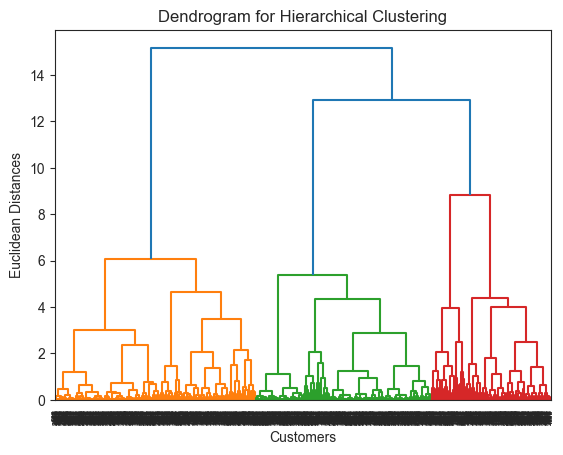

           Recency  Total_Spending  Total Promo
Cluster                                        
0        75.646799      491.635762     0.130243
1        27.515707     1289.338351     0.248691
2        26.359748      204.817610     0.169811
3        63.707006     1631.634554     2.031847


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from concepts import Context  # FCA library


# Extract RFM Features
rfm_df = df[['Recency', 'Total_Spending', 'Total Promo']]
rfm_df.columns = ['Recency', 'Monetary', 'Frequency']  # Rename for clarity

# Normalize the data
rfm_df = (rfm_df - rfm_df.min()) / (rfm_df.max() - rfm_df.min())

# Convert RFM data into binary form based on mean threshold
binary_rfm = (rfm_df > rfm_df.mean()).astype(int)

# Create FCA Context
objects = list(df.index.astype(str))  # Customer IDs as object names
attributes = ['Recency', 'Monetary', 'Frequency']  # Attributes for FCA
binary_matrix = binary_rfm.values.tolist()  # Convert DataFrame to list of lists

context = Context(objects, attributes, binary_matrix)

# Extract conceptual clusters
concepts = context.lattice
fca_clusters = [list(c.extent) for c in concepts]  # Extract customer groups

# Assign FCA-based labels for hierarchical clustering
cluster_labels = np.zeros(len(df))
for idx, group in enumerate(fca_clusters):
    for customer in group:
        cluster_labels[int(customer)] = idx

# Hierarchical Clustering
dendrogram = sch.dendrogram(sch.linkage(rfm_df, method='ward'))
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Customers')
plt.ylabel('Euclidean Distances')
plt.show()

# Apply Agglomerative Clustering (set optimal number of clusters)
hc = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='ward')
df['Cluster'] = hc.fit_predict(rfm_df)

# Display clusters
print(df[['Recency', 'Total_Spending', 'Total Promo', 'Cluster']].groupby('Cluster').mean())

In [16]:
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score

# Apply Agglomerative Clustering
hc = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='ward')
df['Cluster'] = hc.fit_predict(rfm_df)

# Calculate Clustering Evaluation Metrics
db_index = davies_bouldin_score(rfm_df, df['Cluster'])
ch_index = calinski_harabasz_score(rfm_df, df['Cluster'])
silhouette_avg = silhouette_score(rfm_df, df['Cluster'])

# Print the scores
print(f"Davies-Bouldin Index: {db_index:.4f}")
print(f"Calinski-Harabasz Index: {ch_index:.4f}")
print(f"Silhouette Score: {silhouette_avg:.4f}")


Davies-Bouldin Index: 0.9906
Calinski-Harabasz Index: 1198.8259
Silhouette Score: 0.3541


## Advance Customer Segmentation

In [17]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering, MeanShift
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score

# Selecting relevant features for clustering
features = ["Age", "Education", "Marital Status", "Parental Status", "Children", "Income", 
            "Total_Spending", "Days_as_Customer", "Recency", "Wines", "Fruits", "Meat", 
            "Fish", "Sweets", "Gold", "Web", "Catalog", "Store", "Discount Purchases", 
            "Total Promo", "NumWebVisitsMonth"]

X = df[features]

# Handle missing values (if any)
X.fillna(X.median(), inplace=True)

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Apply Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=4)
agglo_labels = agglo.fit_predict(X_scaled)

# Apply Mean-Shift Clustering
mean_shift = MeanShift()
mean_shift_labels = mean_shift.fit_predict(X_scaled)

# Function to calculate clustering evaluation metrics
def evaluate_clustering(X, labels, method_name):
    db_index = davies_bouldin_score(X, labels)
    ch_index = calinski_harabasz_score(X, labels)
    silhouette = silhouette_score(X, labels)
    
    print(f"--- {method_name} ---")
    print(f"Davies-Bouldin Index: {db_index:.4f}")
    print(f"Calinski-Harabasz Index: {ch_index:.4f}")
    print(f"Silhouette Score: {silhouette:.4f}\n")

# Evaluate each clustering method
evaluate_clustering(X_scaled, kmeans_labels, "K-Means")
evaluate_clustering(X_scaled, agglo_labels, "Agglomerative Clustering")
evaluate_clustering(X_scaled, mean_shift_labels, "Mean-Shift")

--- K-Means ---
Davies-Bouldin Index: 2.2222
Calinski-Harabasz Index: 523.0707
Silhouette Score: 0.1699

--- Agglomerative Clustering ---
Davies-Bouldin Index: 2.4130
Calinski-Harabasz Index: 474.9417
Silhouette Score: 0.1736

--- Mean-Shift ---
Davies-Bouldin Index: 0.5417
Calinski-Harabasz Index: 8.1298
Silhouette Score: 0.3696



In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score
from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import fcluster
from scipy.spatial import distance


# Drop rows with missing values
df.dropna(inplace=True)

# Select numerical features for clustering
features = df.select_dtypes(include=[np.number])

# Standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Define Generalized Potential Heuristic Clustering (GPHC)
def gphc_clustering(X, radius=1.5):
    """Applies Generalized Potential Heuristic Clustering (GPHC)"""
    clusters = np.zeros(X.shape[0])
    cluster_id = 1

    for i in range(X.shape[0]):
        if clusters[i] == 0:  # If unassigned
            # Find points within radius
            distances = cdist([X[i]], X, metric='euclidean')[0]
            neighbors = np.where(distances < radius)[0]

            # Assign to cluster
            clusters[neighbors] = cluster_id
            cluster_id += 1
    
    return clusters

# Apply GPHC
clusters = gphc_clustering(X_scaled)

# Convert to integer labels
df['Cluster'] = clusters.astype(int)

# Evaluate clustering performance
davies_bouldin = davies_bouldin_score(X_scaled, df['Cluster'])
calinski_harabasz = calinski_harabasz_score(X_scaled, df['Cluster'])
silhouette = silhouette_score(X_scaled, df['Cluster'])

# Print results
print(f"Davies-Bouldin Index: {davies_bouldin}")
print(f"Calinski-Harabasz Index: {calinski_harabasz}")
print(f"Silhouette Score: {silhouette}")g

Davies-Bouldin Index: 0.3405373759953419
Calinski-Harabasz Index: 42.42211791166507
Silhouette Score: 0.17340848721267338
